In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense
import numpy as np

df = pd.read_csv(r'C:\Users\pinkpigma\pinkpigma的同步盘\KDD研二上\可解释性框架-工作\数据\patient_diagnoses2000_ndc300_with_history_delete4.csv')
# 预测第二天用药，第一天当做历史信息
x = df.iloc[:,5:5+72+2000+300]
y = df.iloc[:,5+72+2000+300:5+72+2000+300+300]


# 将字符串类型的数据转化为数值
from sklearn. preprocessing import LabelEncoder 
x['gender'] = LabelEncoder().fit_transform(x['gender'])
x['ethnicity'] = LabelEncoder().fit_transform(x['ethnicity'])
x['ethnicity_grouped'] = LabelEncoder().fit_transform(x['ethnicity_grouped'])
x['first_hosp_stay'] = LabelEncoder().fit_transform(x['first_hosp_stay'])


# 填补缺失值，用平均值
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
x = imp.fit_transform(x)
y = np.array(y)


# 划分数据集
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
# X_train = X_train.astype(np.float64)
# X_test = X_test.astype(np.float64)
# y_train = y_train.astype(np.int32)
# y_test = y_test.astype(np.int32)




In [6]:
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)



In [4]:
from keras import backend as K
from keras import losses
from keras.layers import Dropout
import numpy as np
import tensorflow as tf
from keras import losses
def JI(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
#     K.print_tensor(y_true, message='y_true = ')

    threshold_value = 0.3

    y_pred = K.cast(K.greater(y_pred, threshold_value), K.floatx())
#     K.print_tensor(y_pred, message='y_pred = ')
    fenzi = K.sum(y_true * y_pred, keepdims=True)
    # true_positives_sum = K.sum(true_positives, keepdims=True)
    fenmu = K.sum(K.cast((K.greater(y_true + y_pred, 0.8)), K.floatx()), keepdims=True)

    return K.mean(fenzi / fenmu, axis=-1)



def deep_model(feature_dim,label_dim, layer_num=1):

    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    model.add(Dense(512, activation='relu', input_dim=feature_dim))
    
    for i in range(layer_num):
        model.add(Dense(512, activation='relu'))
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[JI])
    return model

import keras
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
def train_DNN(X_train,y_train,X_test,y_test,  
               callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss',patience=20)],
               optimizer='adam', 
               metrics=[JI],
               hidden_layer_num=1,
               hidden_layer_units=256,
               batch_size=256, 
               epochs=500,
               hidden_layer_dropout = False,
               input_layer_dropout = False,
               dropout_rate = 0.2,
               use_kernel_regularizer = False,
              kernel_regularizer = keras.regularizers.l2(0.001)
               ):
    feature_dim = X_train.shape[1]
    label_dim = y_train.shape[1]
    model = Sequential()
    print("create model. feature_dim ={}, label_dim ={}".format(feature_dim, label_dim))
    if input_layer_dropout:
        model.add(Dropout(dropout_rate, input_shape=(feature_dim,)))
    else:
        model.add(Dense(hidden_layer_units, activation='relu', input_dim=feature_dim))
    for i in range(hidden_layer_num):
        if hidden_layer_dropout:
            model.add(Dropout(dropout_rate))
        if use_kernel_regularizer:
            model.add(Dense(hidden_layer_units, activation='relu',kernel_regularizer=kernel_regularizer))
        else:
            model.add(Dense(hidden_layer_units, activation='relu'))
        
    model.add(Dense(label_dim, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
    model.summary()
    history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs,callbacks=callbacks_list,validation_data=(X_test,y_test), verbose=1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    JI_list = history.history['val_JI']
    print( "验证集上的最优结果是%s,对应训练轮次是%d" % (max(JI_list),JI_list.index(max(JI_list))+1) )
    return max(JI_list)




create model. feature_dim =2372, label_dim =300
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               607488    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 3s 13ms/step - loss: 0.2853 - JI: 0.0217 - val_loss: 0.1027 - val_JI: 0.0160
Epoch 2/500
166/166 [==============================] - 2s 12ms/step - loss: 0.1043 - JI: 0.0258 - val_loss: 0.0990 - val_JI: 0.0419
Ep

Epoch 56/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0749 - JI: 0.1836 - val_loss: 0.0781 - val_JI: 0.1612
Epoch 57/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0737 - JI: 0.1886 - val_loss: 0.0769 - val_JI: 0.1656
Epoch 58/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0736 - JI: 0.1906 - val_loss: 0.0770 - val_JI: 0.1828
Epoch 59/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0732 - JI: 0.1938 - val_loss: 0.0761 - val_JI: 0.1768
Epoch 60/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0728 - JI: 0.1962 - val_loss: 0.0769 - val_JI: 0.1697
Epoch 61/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0738 - JI: 0.1901 - val_loss: 0.0775 - val_JI: 0.1774
Epoch 62/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0727 - JI: 0.1969 - val_loss: 0.0770 - val_JI: 0.1633
Epoch 63/500
166/166 [==============================] - 2s 12ms/step 

166/166 [==============================] - 2s 12ms/step - loss: 0.0682 - JI: 0.2338 - val_loss: 0.0769 - val_JI: 0.1721
Epoch 118/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0682 - JI: 0.2347 - val_loss: 0.0782 - val_JI: 0.1876
Epoch 119/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0695 - JI: 0.2268 - val_loss: 0.0764 - val_JI: 0.1873
Epoch 120/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0691 - JI: 0.2311 - val_loss: 0.0815 - val_JI: 0.1709
Epoch 121/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0703 - JI: 0.2234 - val_loss: 0.0766 - val_JI: 0.1959


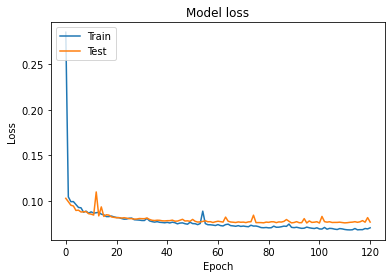

验证集上的最优结果是0.20048002898693085,对应训练轮次是91


0.20048002898693085

In [5]:
# 9:1
train_DNN(X_train,y_train,X_test,y_test)

create model. feature_dim =2372, label_dim =300
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               607488    
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
148/148 [==============================] - 4s 15ms/step - loss: 0.2860 - JI: 0.0224 - val_loss: 0.1066 - val_JI: 0.0111
Epoch 2/500
148/148 [==============================] - 2s 12ms/step - loss: 0.1145 - JI: 0.0187 - val_loss: 0.1000 - val_JI: 0.0229


148/148 [==============================] - 2s 16ms/step - loss: 0.0746 - JI: 0.1833 - val_loss: 0.0769 - val_JI: 0.1566
Epoch 57/500
148/148 [==============================] - 2s 15ms/step - loss: 0.0733 - JI: 0.1913 - val_loss: 0.0851 - val_JI: 0.1419
Epoch 58/500
148/148 [==============================] - 2s 14ms/step - loss: 0.0740 - JI: 0.1893 - val_loss: 0.0769 - val_JI: 0.1558
Epoch 59/500
148/148 [==============================] - 2s 13ms/step - loss: 0.0729 - JI: 0.1953 - val_loss: 0.0773 - val_JI: 0.1581
Epoch 60/500
148/148 [==============================] - 2s 14ms/step - loss: 0.0724 - JI: 0.1979 - val_loss: 0.0775 - val_JI: 0.1586
Epoch 61/500
148/148 [==============================] - 2s 13ms/step - loss: 0.0727 - JI: 0.1974 - val_loss: 0.0768 - val_JI: 0.1747
Epoch 62/500
148/148 [==============================] - 2s 12ms/step - loss: 0.0747 - JI: 0.1884 - val_loss: 0.0786 - val_JI: 0.1478
Epoch 63/500
148/148 [==============================] - 2s 12ms/step - loss: 0.074

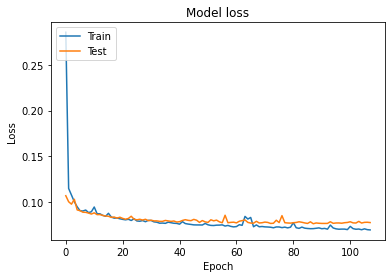

验证集上的最优结果是0.19433769583702087,对应训练轮次是89


0.19433769583702087

In [7]:
#8:2
train_DNN(X_train,y_train,X_test,y_test)

create model. feature_dim =2372, label_dim =300
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               607488    
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 3s 13ms/step - loss: 0.3063 - JI: 0.0237 - val_loss: 0.1039 - val_JI: 0.0207
Epoch 2/500
166/166 [==============================] - 2s 12ms/step - loss: 0.1044 - JI: 0.0288 - val_loss: 0.1019 - val_JI: 0.0457


Epoch 56/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0737 - JI: 0.1904 - val_loss: 0.0772 - val_JI: 0.1544
Epoch 57/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0735 - JI: 0.1908 - val_loss: 0.0773 - val_JI: 0.1704
Epoch 58/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0734 - JI: 0.1926 - val_loss: 0.0774 - val_JI: 0.1705
Epoch 59/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0729 - JI: 0.1958 - val_loss: 0.0771 - val_JI: 0.1670
Epoch 60/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0727 - JI: 0.1975 - val_loss: 0.0769 - val_JI: 0.1705
Epoch 61/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0725 - JI: 0.1994 - val_loss: 0.0771 - val_JI: 0.1810
Epoch 62/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0720 - JI: 0.2024 - val_loss: 0.0766 - val_JI: 0.1792
Epoch 63/500
166/166 [==============================] - 2s 11ms/step 

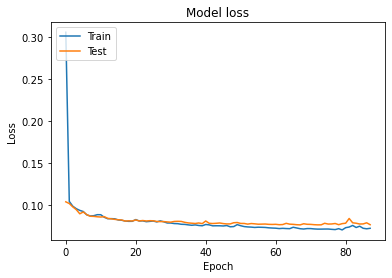

验证集上的最优结果是0.18592913448810577,对应训练轮次是78
create model. feature_dim =2372, label_dim =300
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               607488    
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 3s 13ms/step - loss: 0.3250 - JI: 0.0200 - val_loss: 0.1575 - val_JI: 0.0203
Epoch 2/500
166/166 [==============================] - 2s 12ms/step - loss: 0.1017 - JI: 0.0

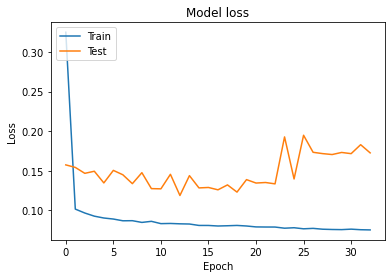

验证集上的最优结果是0.16741110384464264,对应训练轮次是30
create model. feature_dim =2372, label_dim =300
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 256)               607488    
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 3s 14ms/step - loss: 0.3302 - JI: 0.0231 - val_loss: 0.1033 - val_JI: 0.0139
Epoch 2/500
166/166 [==============================] - 2s 12ms/step - loss: 0.1067 - JI: 0.0

166/166 [==============================] - 2s 11ms/step - loss: 0.0729 - JI: 0.1968 - val_loss: 0.0754 - val_JI: 0.1860
Epoch 56/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0721 - JI: 0.2019 - val_loss: 0.0753 - val_JI: 0.1741
Epoch 57/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0719 - JI: 0.2035 - val_loss: 0.0759 - val_JI: 0.1740
Epoch 58/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0716 - JI: 0.2066 - val_loss: 0.0778 - val_JI: 0.1672
Epoch 59/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0740 - JI: 0.1987 - val_loss: 0.0752 - val_JI: 0.1803
Epoch 60/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0733 - JI: 0.2036 - val_loss: 0.0757 - val_JI: 0.1783
Epoch 61/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0756 - JI: 0.1909 - val_loss: 0.0768 - val_JI: 0.1750
Epoch 62/500
166/166 [==============================] - 2s 11ms/step - loss: 0.073

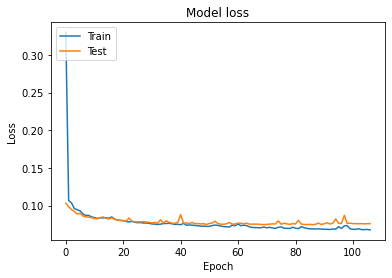

验证集上的最优结果是0.19578015804290771,对应训练轮次是76
create model. feature_dim =2372, label_dim =300
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               607488    
                                                                 
 dense_16 (Dense)            (None, 256)               65792     
                                                                 
 dense_17 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 3s 13ms/step - loss: 0.2899 - JI: 0.0224 - val_loss: 0.1062 - val_JI: 0.0164
Epoch 2/500
166/166 [==============================] - 2s 13ms/step - loss: 0.1116 - JI: 0.0

166/166 [==============================] - 2s 13ms/step - loss: 0.0739 - JI: 0.1848 - val_loss: 0.0791 - val_JI: 0.1596
Epoch 56/500
166/166 [==============================] - 2s 14ms/step - loss: 0.0733 - JI: 0.1887 - val_loss: 0.0778 - val_JI: 0.1789
Epoch 57/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0734 - JI: 0.1884 - val_loss: 0.0783 - val_JI: 0.1812
Epoch 58/500
166/166 [==============================] - 2s 14ms/step - loss: 0.0732 - JI: 0.1904 - val_loss: 0.0784 - val_JI: 0.1688
Epoch 59/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0729 - JI: 0.1927 - val_loss: 0.0777 - val_JI: 0.1793
Epoch 60/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0727 - JI: 0.1945 - val_loss: 0.0783 - val_JI: 0.1828
Epoch 61/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0728 - JI: 0.1946 - val_loss: 0.0772 - val_JI: 0.1807
Epoch 62/500
166/166 [==============================] - 2s 13ms/step - loss: 0.073

166/166 [==============================] - 2s 13ms/step - loss: 0.0698 - JI: 0.2215 - val_loss: 0.0779 - val_JI: 0.1937
Epoch 117/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0699 - JI: 0.2212 - val_loss: 0.0767 - val_JI: 0.1825
Epoch 118/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0716 - JI: 0.2109 - val_loss: 0.0783 - val_JI: 0.1894
Epoch 119/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0703 - JI: 0.2165 - val_loss: 0.0776 - val_JI: 0.1760
Epoch 120/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0696 - JI: 0.2229 - val_loss: 0.0770 - val_JI: 0.1920
Epoch 121/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0687 - JI: 0.2284 - val_loss: 0.0769 - val_JI: 0.2004


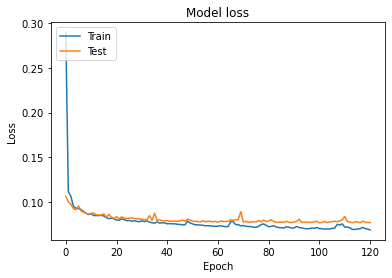

验证集上的最优结果是0.20252974331378937,对应训练轮次是102
create model. feature_dim =2372, label_dim =300
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 256)               607488    
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dense_20 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 3s 13ms/step - loss: 0.2934 - JI: 0.0253 - val_loss: 0.1053 - val_JI: 0.0164
Epoch 2/500
166/166 [==============================] - 2s 11ms/step - loss: 0.1070 - JI: 0.

166/166 [==============================] - 2s 12ms/step - loss: 0.0723 - JI: 0.2008 - val_loss: 0.0821 - val_JI: 0.1619


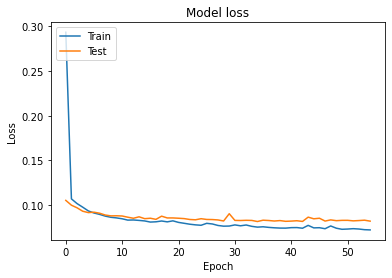

验证集上的最优结果是0.1833975464105606,对应训练轮次是50
create model. feature_dim =2372, label_dim =300
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 256)               607488    
                                                                 
 dense_22 (Dense)            (None, 256)               65792     
                                                                 
 dense_23 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 3s 13ms/step - loss: 0.3163 - JI: 0.0215 - val_loss: 0.1094 - val_JI: 0.0128
Epoch 2/500
166/166 [==============================] - 2s 12ms/step - loss: 0.1036 - JI: 0.02

Epoch 56/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0706 - JI: 0.2170 - val_loss: 0.0764 - val_JI: 0.1808
Epoch 57/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0707 - JI: 0.2167 - val_loss: 0.0778 - val_JI: 0.1880
Epoch 58/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0705 - JI: 0.2181 - val_loss: 0.0766 - val_JI: 0.1871
Epoch 59/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0708 - JI: 0.2183 - val_loss: 0.0792 - val_JI: 0.1759
Epoch 60/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0723 - JI: 0.2166 - val_loss: 0.0764 - val_JI: 0.1691
Epoch 61/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0714 - JI: 0.2184 - val_loss: 0.0781 - val_JI: 0.1801
Epoch 62/500
166/166 [==============================] - 2s 11ms/step - loss: 0.0702 - JI: 0.2214 - val_loss: 0.0775 - val_JI: 0.1714
Epoch 63/500
166/166 [==============================] - 2s 12ms/step 

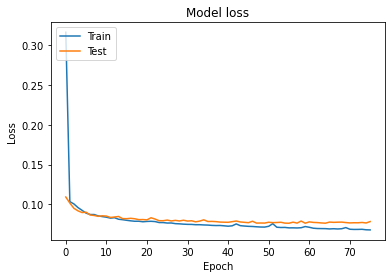

验证集上的最优结果是0.19292505085468292,对应训练轮次是73
create model. feature_dim =2372, label_dim =300
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 256)               607488    
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 dense_26 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 4s 18ms/step - loss: 0.2975 - JI: 0.0219 - val_loss: 0.1103 - val_JI: 0.0191
Epoch 2/500
166/166 [==============================] - 1s 8ms/step - loss: 0.1103 - JI: 0.01

Epoch 56/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0744 - JI: 0.1847 - val_loss: 0.0769 - val_JI: 0.1607
Epoch 57/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0739 - JI: 0.1893 - val_loss: 0.0777 - val_JI: 0.1609
Epoch 58/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0731 - JI: 0.1927 - val_loss: 0.0762 - val_JI: 0.1897
Epoch 59/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0731 - JI: 0.1940 - val_loss: 0.0757 - val_JI: 0.1828
Epoch 60/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0741 - JI: 0.1913 - val_loss: 0.0766 - val_JI: 0.1785
Epoch 61/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0733 - JI: 0.1929 - val_loss: 0.0761 - val_JI: 0.1680
Epoch 62/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0727 - JI: 0.1970 - val_loss: 0.0757 - val_JI: 0.1720
Epoch 63/500
166/166 [==============================] - 2s 12ms/step 

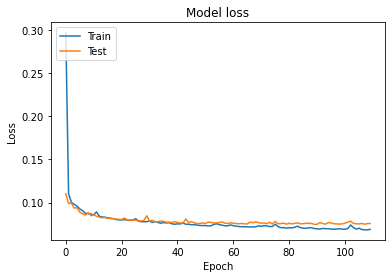

验证集上的最优结果是0.19851835072040558,对应训练轮次是110
create model. feature_dim =2372, label_dim =300
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 256)               607488    
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dense_29 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 4s 16ms/step - loss: 0.2986 - JI: 0.0210 - val_loss: 0.1070 - val_JI: 0.0150
Epoch 2/500
166/166 [==============================] - 2s 14ms/step - loss: 0.1064 - JI: 0.

166/166 [==============================] - 2s 12ms/step - loss: 0.0720 - JI: 0.2019 - val_loss: 0.0762 - val_JI: 0.1886
Epoch 56/500
166/166 [==============================] - ETA: 0s - loss: 0.0716 - JI: 0.20 - 2s 13ms/step - loss: 0.0716 - JI: 0.2036 - val_loss: 0.0763 - val_JI: 0.1786
Epoch 57/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0711 - JI: 0.2082 - val_loss: 0.0784 - val_JI: 0.1795
Epoch 58/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0713 - JI: 0.2069 - val_loss: 0.0763 - val_JI: 0.1845
Epoch 59/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0720 - JI: 0.2046 - val_loss: 0.0772 - val_JI: 0.1648
Epoch 60/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0712 - JI: 0.2075 - val_loss: 0.0765 - val_JI: 0.1738
Epoch 61/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0706 - JI: 0.2120 - val_loss: 0.0754 - val_JI: 0.1980
Epoch 62/500
166/166 [========================

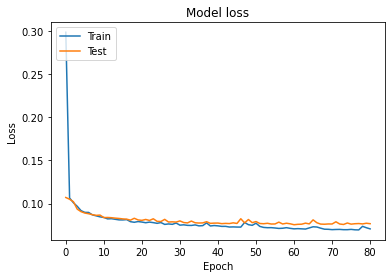

验证集上的最优结果是0.20343098044395447,对应训练轮次是54
create model. feature_dim =2372, label_dim =300
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 256)               607488    
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dense_32 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 4s 15ms/step - loss: 0.2968 - JI: 0.0223 - val_loss: 0.1047 - val_JI: 0.0207
Epoch 2/500
166/166 [==============================] - 2s 12ms/step - loss: 0.1043 - JI: 0.

Epoch 56/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0737 - JI: 0.1899 - val_loss: 0.0786 - val_JI: 0.1640
Epoch 57/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0732 - JI: 0.1923 - val_loss: 0.0774 - val_JI: 0.1916
Epoch 58/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0724 - JI: 0.1982 - val_loss: 0.0778 - val_JI: 0.1846
Epoch 59/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0727 - JI: 0.1963 - val_loss: 0.0771 - val_JI: 0.1790
Epoch 60/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0721 - JI: 0.2011 - val_loss: 0.0776 - val_JI: 0.1750
Epoch 61/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0719 - JI: 0.2022 - val_loss: 0.0770 - val_JI: 0.1827
Epoch 62/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0719 - JI: 0.2022 - val_loss: 0.0829 - val_JI: 0.1629
Epoch 63/500
166/166 [==============================] - 2s 13ms/step 

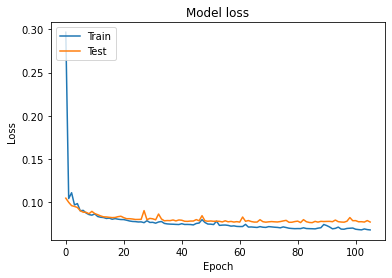

验证集上的最优结果是0.19968383014202118,对应训练轮次是102
create model. feature_dim =2372, label_dim =300
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 256)               607488    
                                                                 
 dense_34 (Dense)            (None, 256)               65792     
                                                                 
 dense_35 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
166/166 [==============================] - 3s 14ms/step - loss: 0.2519 - JI: 0.0224 - val_loss: 0.1044 - val_JI: 0.0165
Epoch 2/500
166/166 [==============================] - 2s 12ms/step - loss: 0.1100 - JI: 0

Epoch 56/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0764 - JI: 0.1867 - val_loss: 0.0787 - val_JI: 0.1434
Epoch 57/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0739 - JI: 0.1906 - val_loss: 0.0810 - val_JI: 0.1626
Epoch 58/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0743 - JI: 0.1889 - val_loss: 0.0769 - val_JI: 0.1583
Epoch 59/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0751 - JI: 0.1915 - val_loss: 0.0776 - val_JI: 0.1670
Epoch 60/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0731 - JI: 0.1935 - val_loss: 0.0785 - val_JI: 0.1765
Epoch 61/500
166/166 [==============================] - 2s 12ms/step - loss: 0.0731 - JI: 0.1942 - val_loss: 0.0765 - val_JI: 0.1724
Epoch 62/500
166/166 [==============================] - 2s 13ms/step - loss: 0.0724 - JI: 0.1997 - val_loss: 0.0773 - val_JI: 0.1581
Epoch 63/500
166/166 [==============================] - 2s 12ms/step 

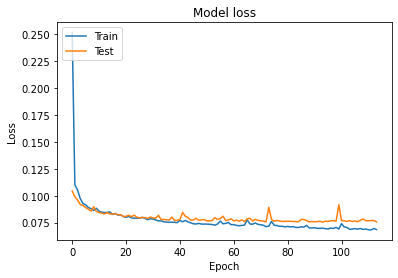

验证集上的最优结果是0.19925563037395477,对应训练轮次是114


[0.18592913448810577,
 0.16741110384464264,
 0.19578015804290771,
 0.20252974331378937,
 0.1833975464105606,
 0.19292505085468292,
 0.19851835072040558,
 0.20343098044395447,
 0.19968383014202118,
 0.19925563037395477]

In [8]:
# 十折交叉
results = []
# 十折交叉验证
from sklearn.model_selection import KFold
import numpy
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# define 10-fold cross validation test harness
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
for train, test in kfold.split(x, y):
    X_train = x[train].astype(np.float64)
    X_test = x[test].astype(np.float64)
    y_train = y[train].astype(np.int32)
    y_test = y[test].astype(np.int32)
    results.append(train_DNN(X_train,y_train,X_test,y_test))
results

In [9]:
# 划分数据集 9:1
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

create model. feature_dim =2372, label_dim =300
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 512)               1214976   
                                                                 
 dense_37 (Dense)            (None, 512)               262656    
                                                                 
 dense_38 (Dense)            (None, 300)               153900    
                                                                 
Total params: 1,631,532
Trainable params: 1,631,532
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
148/148 [==============================] - 3s 15ms/step - loss: 0.3298 - JI: 0.0282 - val_loss: 0.1170 - val_JI: 0.0169
Epoch 2/500
148/148 [==============================] - 2s 14ms/step - loss: 0.1134 - JI: 0.0250 - val_loss: 0.1061 - val_JI: 0.

148/148 [==============================] - 3s 20ms/step - loss: 0.0719 - JI: 0.2026 - val_loss: 0.0773 - val_JI: 0.1676
Epoch 57/500
148/148 [==============================] - 3s 20ms/step - loss: 0.0717 - JI: 0.2035 - val_loss: 0.0759 - val_JI: 0.1778
Epoch 58/500
148/148 [==============================] - 3s 21ms/step - loss: 0.0718 - JI: 0.2031 - val_loss: 0.0771 - val_JI: 0.1759
Epoch 59/500
148/148 [==============================] - 3s 20ms/step - loss: 0.0712 - JI: 0.2078 - val_loss: 0.0786 - val_JI: 0.1766
Epoch 60/500
148/148 [==============================] - 3s 21ms/step - loss: 0.0723 - JI: 0.2012 - val_loss: 0.0764 - val_JI: 0.1662
Epoch 61/500
148/148 [==============================] - 3s 21ms/step - loss: 0.0713 - JI: 0.2078 - val_loss: 0.0776 - val_JI: 0.1663
Epoch 62/500
148/148 [==============================] - 3s 21ms/step - loss: 0.0716 - JI: 0.2065 - val_loss: 0.0761 - val_JI: 0.1875
Epoch 63/500
148/148 [==============================] - 3s 21ms/step - loss: 0.071

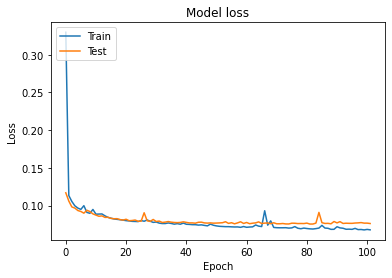

验证集上的最优结果是0.19520960748195648,对应训练轮次是97


0.19520960748195648

In [10]:
train_DNN(X_train,y_train,X_test,y_test, hidden_layer_units=512)

create model. feature_dim =2372, label_dim =300
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 256)               607488    
                                                                 
 dense_40 (Dense)            (None, 256)               65792     
                                                                 
 dense_41 (Dense)            (None, 300)               77100     
                                                                 
Total params: 750,380
Trainable params: 750,380
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
148/148 [==============================] - 3s 14ms/step - loss: 0.3670 - JI: 0.0256 - val_loss: 0.1284 - val_JI: 0.0202
Epoch 2/500
148/148 [==============================] - 2s 12ms/step - loss: 0.1265 - JI: 0.0264 - val_loss: 0.1233 - val_JI: 0.0387

148/148 [==============================] - 2s 12ms/step - loss: 0.0745 - JI: 0.2007 - val_loss: 0.0783 - val_JI: 0.1804
Epoch 57/500
148/148 [==============================] - 1s 9ms/step - loss: 0.0744 - JI: 0.2006 - val_loss: 0.0789 - val_JI: 0.1775
Epoch 58/500
148/148 [==============================] - 1s 8ms/step - loss: 0.0740 - JI: 0.2027 - val_loss: 0.0788 - val_JI: 0.1672
Epoch 59/500
148/148 [==============================] - 1s 8ms/step - loss: 0.0739 - JI: 0.2044 - val_loss: 0.0789 - val_JI: 0.1786
Epoch 60/500
148/148 [==============================] - 1s 9ms/step - loss: 0.0740 - JI: 0.2020 - val_loss: 0.0794 - val_JI: 0.1768
Epoch 61/500
148/148 [==============================] - 2s 11ms/step - loss: 0.0740 - JI: 0.2017 - val_loss: 0.0777 - val_JI: 0.1834
Epoch 62/500
148/148 [==============================] - 2s 12ms/step - loss: 0.0735 - JI: 0.2058 - val_loss: 0.0781 - val_JI: 0.1708
Epoch 63/500
148/148 [==============================] - 2s 12ms/step - loss: 0.0731 - 

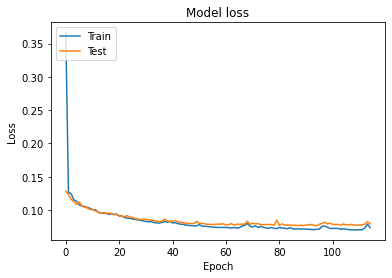

验证集上的最优结果是0.19946123659610748,对应训练轮次是111


0.19946123659610748

In [11]:
train_DNN(X_train,y_train,X_test,y_test,use_kernel_regularizer = True,kernel_regularizer = tf.keras.regularizers.l1(0.00001))

create model. feature_dim =2372, label_dim =300
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 256)               607488    
                                                                 
 dense_43 (Dense)            (None, 256)               65792     
                                                                 
 dense_44 (Dense)            (None, 256)               65792     
                                                                 
 dense_45 (Dense)            (None, 256)               65792     
                                                                 
 dense_46 (Dense)            (None, 256)               65792     
                                                                 
 dense_47 (Dense)            (None, 300)               77100     
                                                                 
Total

148/148 [==============================] - 2s 16ms/step - loss: 0.0810 - JI: 0.1695 - val_loss: 0.0829 - val_JI: 0.1689
Epoch 54/500
148/148 [==============================] - 2s 16ms/step - loss: 0.0803 - JI: 0.1698 - val_loss: 0.0822 - val_JI: 0.1656
Epoch 55/500
148/148 [==============================] - 2s 16ms/step - loss: 0.0801 - JI: 0.1716 - val_loss: 0.0813 - val_JI: 0.1645
Epoch 56/500
148/148 [==============================] - 2s 15ms/step - loss: 0.0790 - JI: 0.1773 - val_loss: 0.0809 - val_JI: 0.1679
Epoch 57/500
148/148 [==============================] - 2s 15ms/step - loss: 0.0792 - JI: 0.1746 - val_loss: 0.0808 - val_JI: 0.1579
Epoch 58/500
148/148 [==============================] - 2s 15ms/step - loss: 0.0785 - JI: 0.1776 - val_loss: 0.0804 - val_JI: 0.1692
Epoch 59/500
148/148 [==============================] - 2s 16ms/step - loss: 0.0785 - JI: 0.1761 - val_loss: 0.0819 - val_JI: 0.1614
Epoch 60/500
148/148 [==============================] - 2s 16ms/step - loss: 0.078

148/148 [==============================] - 2s 16ms/step - loss: 0.0741 - JI: 0.2056 - val_loss: 0.0796 - val_JI: 0.1747
Epoch 115/500
148/148 [==============================] - 2s 15ms/step - loss: 0.0738 - JI: 0.2090 - val_loss: 0.0789 - val_JI: 0.1818
Epoch 116/500
148/148 [==============================] - 2s 16ms/step - loss: 0.0738 - JI: 0.2080 - val_loss: 0.0786 - val_JI: 0.1882
Epoch 117/500
148/148 [==============================] - 2s 15ms/step - loss: 0.0735 - JI: 0.2118 - val_loss: 0.0787 - val_JI: 0.1840
Epoch 118/500
148/148 [==============================] - 2s 15ms/step - loss: 0.0736 - JI: 0.2105 - val_loss: 0.0794 - val_JI: 0.1778
Epoch 119/500
148/148 [==============================] - 2s 15ms/step - loss: 0.0737 - JI: 0.2087 - val_loss: 0.0793 - val_JI: 0.1917
Epoch 120/500
148/148 [==============================] - 2s 16ms/step - loss: 0.0738 - JI: 0.2093 - val_loss: 0.0803 - val_JI: 0.1729
Epoch 121/500
148/148 [==============================] - 2s 16ms/step - loss

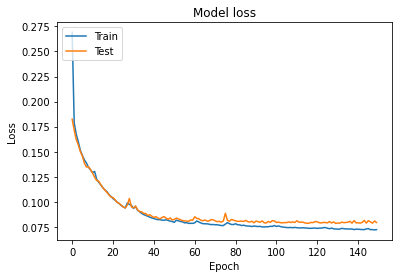

验证集上的最优结果是0.1948385089635849,对应训练轮次是109


0.1948385089635849

In [12]:
train_DNN(X_train,y_train,X_test,y_test,use_kernel_regularizer = True,hidden_layer_num=4,kernel_regularizer = tf.keras.regularizers.l1(0.00001))